# Alphanumeric Character Recognition using CNNs

**Project Title:** Alphanumeric Character Recognition using Convolutional Neural Networks
(0-9, A-Z).

## 1. Environment Setup and Library Imports

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Keras version: {keras.__version__}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2025-06-01 06:16:45.138142: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 06:16:45.271299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748747805.327518   48407 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748747805.344648   48407 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748747805.457573   48407 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version: 3.10.0


## 2. Data Loading and Preparation

According to the requirements, we need to use the EMNIST (Extended MNIST) dataset which contains both digits and letters. We'll use the 'byclass' split which includes:
- Digits: 0-9 (10 classes)
- Uppercase letters: A-Z (26 classes) 
- Lowercase letters: a-z (26 classes)
- Total: 62 classes

The EMNIST dataset provides 28x28 grayscale images similar to MNIST but with a much larger character set.

In [2]:
# Load EMNIST dataset from local path
import os
import pandas as pd
import numpy as np

print("Loading EMNIST dataset from local path...")

# Path to the EMNIST dataset
dataset_path = "/home/omar/.cache/kagglehub/datasets/crawford/emnist/versions/3"

try:
    # List files in the dataset directory
    files = os.listdir(dataset_path)
    print(f"Files in dataset directory: {files}")
    
    # Look for EMNIST ByClass files (62 classes: 0-9, A-Z, a-z)
    train_file = None
    test_file = None
    
    for file in files:
        if 'byclass' in file.lower() and 'train' in file.lower():
            train_file = file
        elif 'byclass' in file.lower() and 'test' in file.lower():
            test_file = file
    
    if train_file and test_file:
        print(f"Found training file: {train_file}")
        print(f"Found test file: {test_file}")
        
        # Load the CSV files
        train_data = pd.read_csv(os.path.join(dataset_path, train_file))
        # Filter to include only classes 0-35 (digits 0-9 and uppercase A-Z)
        train_data = train_data[train_data.iloc[:, 0].isin(np.arange(0, 36))]
        test_data = pd.read_csv(os.path.join(dataset_path, test_file))
        test_data = test_data[test_data.iloc[:, 0].isin(np.arange(0, 36))]
        
        print(f"Training data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        # Extract features and labels
        # First column is label, rest are pixel values
        x_train = train_data.iloc[:, 1:].values
        y_train = train_data.iloc[:, 0].values
        x_test = test_data.iloc[:, 1:].values
        y_test = test_data.iloc[:, 0].values
        
        # Reshape from flat arrays to 28x28 images
        x_train = x_train.reshape(-1, 28, 28)
        x_test = x_test.reshape(-1, 28, 28)
        
        # EMNIST images need to be rotated and flipped to match standard orientation
        x_train = np.rot90(x_train, k=3, axes=(1, 2))  # Rotate 270 degrees
        x_test = np.rot90(x_test, k=3, axes=(1, 2))    # Rotate 270 degrees
        x_train = np.flip(x_train, axis=2)  # Flip horizontally
        x_test = np.flip(x_test, axis=2)    # Flip horizontally
        
        num_classes = len(np.unique(y_train))
        
        print(f"\nEMNIST ByClass Dataset loaded successfully!")
        print(f"Training data shape: {x_train.shape}")
        print(f"Training labels shape: {y_train.shape}")
        print(f"Test data shape: {x_test.shape}")
        print(f"Test labels shape: {y_test.shape}")
        print(f"Number of classes: {num_classes}")
        print(f"Label range: {np.min(y_train)} to {np.max(y_train)}")
        
        # Create class mapping
        class_names = []
        # Classes 0-9: Digits
        class_names.extend([str(i) for i in range(10)])
        # Classes 10-35: Uppercase letters A-Z
        class_names.extend([chr(ord('A') + i) for i in range(26)])
        
        print(f"Class mapping: 0-9 (digits), 10-35 (A-Z)")
        print(f"Sample classes: {class_names[:10]}...{class_names[-10:]}")
        
    else:
        raise FileNotFoundError("Could not find ByClass train/test files")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e

Loading EMNIST dataset from local path...
Files in dataset directory: ['emnist-byclass-train.csv', 'emnist-letters-mapping.txt', 'emnist-bymerge-mapping.txt', 'emnist-digits-mapping.txt', 'emnist-mnist-mapping.txt', 'emnist-byclass-test.csv', 'emnist_source_files', 'emnist-balanced-mapping.txt', 'emnist-digits-train.csv', 'emnist-byclass-mapping.txt', 'emnist-mnist-test.csv', 'emnist-mnist-train.csv', 'emnist-bymerge-test.csv', 'emnist-letters-test.csv', 'emnist-bymerge-train.csv', 'emnist-balanced-test.csv', 'emnist-balanced-train.csv', 'emnist-digits-test.csv', 'emnist-letters-train.csv']
Found training file: emnist-byclass-train.csv
Found test file: emnist-byclass-test.csv
Training data shape: (533992, 785)
Test data shape: (89263, 785)

EMNIST ByClass Dataset loaded successfully!
Training data shape: (533992, 28, 28)
Training labels shape: (533992,)
Test data shape: (89263, 28, 28)
Test labels shape: (89263,)
Number of classes: 36
Label range: 0 to 35
Class mapping: 0-9 (digits), 1

## 3. Image Preprocessing

According to the requirements, we need to implement the following preprocessing steps:
- Grayscale conversion (already done for MNIST)
- Normalization: Scale pixel values to [0, 1] range
- Reshaping for CNN input: Add channel dimension
- Label encoding: Convert to one-hot encoded vectors

The preprocessing formula for normalization: I_norm = I/255

In [3]:
# Image Preprocessing
print("Original data shapes:")
print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Pixel value range: {x_train.min()} to {x_train.max()}")

# 1. Normalization: Scale pixel values to [0, 1] range
# Formula: I_norm = I/255
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

print(f"\nAfter normalization:")
print(f"Pixel value range: {x_train_norm.min()} to {x_train_norm.max()}")

# 2. Reshaping for CNN input: Add channel dimension
# From (28, 28) to (28, 28, 1)
x_train_reshaped = x_train_norm.reshape(x_train_norm.shape[0], 28, 28, 1)
x_test_reshaped = x_test_norm.reshape(x_test_norm.shape[0], 28, 28, 1)

print(f"\nAfter reshaping:")
print(f"x_train: {x_train_reshaped.shape}, x_test: {x_test_reshaped.shape}")

# 3. Label encoding: Convert to one-hot encoded vectors
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

print(f"\nAfter one-hot encoding:")
print(f"y_train: {y_train_onehot.shape}, y_test: {y_test_onehot.shape}")
print(f"Example label before: {y_train[0]}")
print(f"Example label after: {y_train_onehot[0]}")

# Store preprocessed data
x_train_processed = x_train_reshaped
x_test_processed = x_test_reshaped
y_train_processed = y_train_onehot
y_test_processed = y_test_onehot

Original data shapes:
x_train: (533992, 28, 28), x_test: (89263, 28, 28)
y_train: (533992,), y_test: (89263,)


Pixel value range: 0 to 255

After normalization:
Pixel value range: 0.0 to 1.0

After reshaping:
x_train: (533992, 28, 28, 1), x_test: (89263, 28, 28, 1)

After one-hot encoding:
y_train: (533992, 36), y_test: (89263, 36)
Example label before: 6
Example label after: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


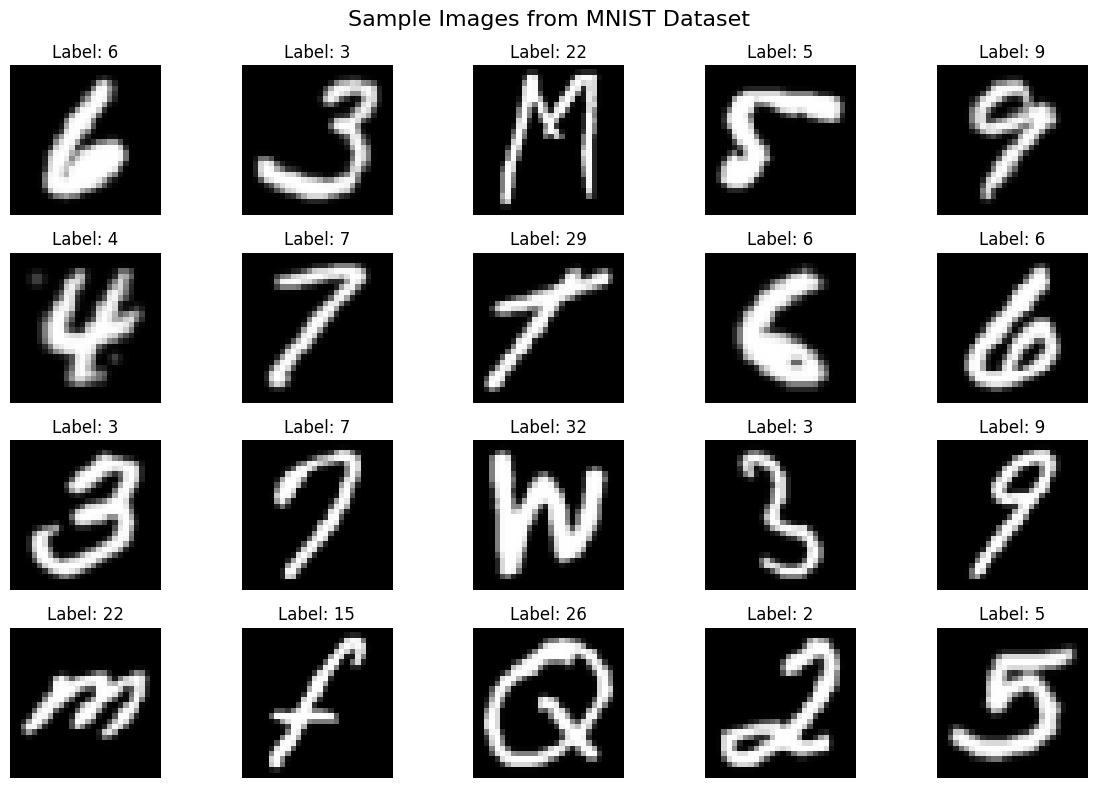

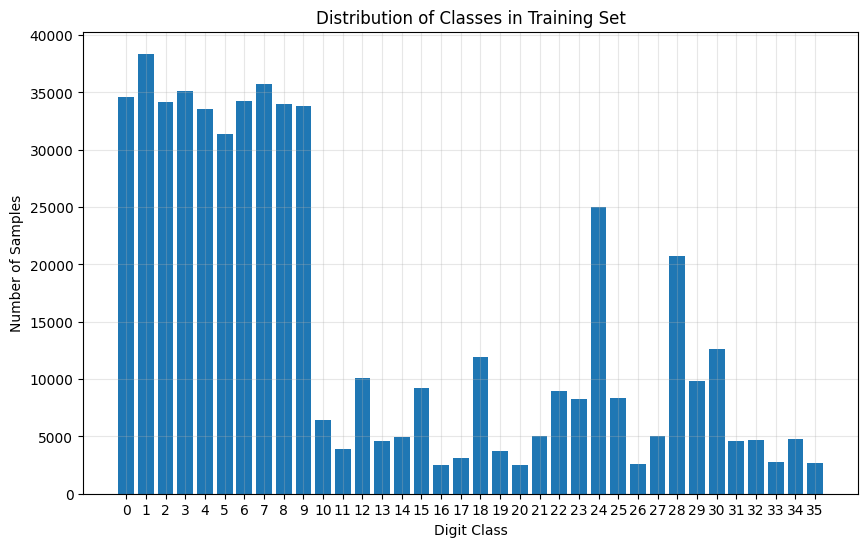

In [4]:
# Visualize sample images from the dataset
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')

plt.suptitle('Sample Images from MNIST Dataset', fontsize=16)
plt.tight_layout()
plt.show()

# Show distribution of classes
plt.figure(figsize=(10, 6))
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.xticks(unique)
plt.grid(True, alpha=0.3)
plt.show()

## 4. CNN Architecture for Feature Extraction

According to the requirements, we need to implement a CNN with the following architecture:
- **Input Layer:** Shape (28, 28, 1) for grayscale images
- **Layer 1:** Conv2D with 32 filters, 3x3 kernel, ReLU activation
- **Layer 2:** MaxPooling2D with 2x2 pool size
- **Layer 3:** Conv2D with 64 filters, 3x3 kernel, ReLU activation  
- **Layer 4:** MaxPooling2D with 2x2 pool size
- **Layer 5:** Flatten layer (this will serve as feature extractor)
- **Layer 6:** Dense layer with 128 units, ReLU activation
- **Layer 7:** Output Dense layer with num_classes units, Softmax activation

The Flatten layer output will be used as feature vectors for correlation-based classification.

In [5]:
# Define CNN Architecture for Extended Alphanumeric Dataset
def create_cnn_model(input_shape=(28, 28, 1), num_classes=62):
    """
    Create CNN model according to requirements specifications
    Updated for 62 classes (0-9, A-Z, a-z)
    """
    model = keras.Sequential([
        # Input Layer
        keras.Input(shape=input_shape),
        
        # Layer 1: Conv2D with 32 filters, 3x3 kernel, ReLU activation
        layers.Conv2D(32, (3, 3), activation='relu', padding='valid', name='conv2d_1'),
        
        # Layer 2: MaxPooling2D with 2x2 pool size
        layers.MaxPooling2D((2, 2), name='maxpool2d_1'),
        
        # Layer 3: Conv2D with 64 filters, 3x3 kernel, ReLU activation
        layers.Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv2d_2'),
        
        # Layer 4: MaxPooling2D with 2x2 pool size
        layers.MaxPooling2D((2, 2), name='maxpool2d_2'),
        
        # Layer 5: Flatten layer (feature extractor)
        layers.Flatten(name='flatten'),
        
        # Layer 6: Dense layer with 128 units, ReLU activation
        layers.Dense(128, activation='relu', name='dense_1'),
        
        # Layer 7: Output Dense layer with 62 classes for alphanumeric characters
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Create the model with 62 classes
cnn_model = create_cnn_model(input_shape=(28, 28, 1), num_classes=num_classes)

# Display model architecture
print("CNN Model Architecture for Extended Alphanumeric Dataset:")
print(f"Number of classes: {num_classes}")
cnn_model.summary()

# Show the class mapping
print(f"\nClass Mapping:")
print(f"0-9: Digits")
print(f"10-35: Uppercase letters (A-Z)")
print(f"Total classes: {num_classes}")

I0000 00:00:1748747837.644974   48407 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2153 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


CNN Model Architecture for Extended Alphanumeric Dataset:
Number of classes: 36


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,388 (892.14 KB)

 Trainable params: 228,388 (892.14 KB)

 Non-trainable params: 0 (0.00 B)


Class Mapping:
0-9: Digits
10-35: Uppercase letters (A-Z)
Total classes: 36


## 5. CNN Training

According to the requirements, we need to train the CNN with:
- **Optimizer:** Adam
- **Loss Function:** Categorical Cross-Entropy
- **Training Parameters:** 
  - Epochs: 5-10 (adjustable based on convergence)
  - Batch Size: 32
  - Validation Split: 20% of training data
- **Metrics:** Track accuracy during training and validation
- **Visualization:** Plot training & validation accuracy and loss curves

In [6]:
# Compile the CNN model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("Optimizer: Adam")
print("Loss Function: Categorical Cross-Entropy")
print("Metrics: Accuracy")


# Train the model
print("\nStarting CNN training...")
history = cnn_model.fit(
    x_train_processed, y_train_processed,
    batch_size=16,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

print("\nCNN training completed!")


Model compiled successfully!
Optimizer: Adam
Loss Function: Categorical Cross-Entropy
Metrics: Accuracy

Starting CNN training...
Epoch 1/20


I0000 00:00:1748747840.360614   48474 service.cc:152] XLA service 0x7f14380099d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748747840.360654   48474 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-06-01 06:17:20.399595: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748747840.545793   48474 cuda_dnn.cc:529] Loaded cuDNN version 90300


  121/26700 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - accuracy: 0.3299 - loss: 2.6816  

I0000 00:00:1748747842.956161   48474 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26700/26700 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.8733 - loss: 0.3807 - val_accuracy: 0.9254 - val_loss: 0.1973
Epoch 2/20
26700/26700 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.9259 - loss: 0.1932 - val_accuracy: 0.9282 - val_loss: 0.1895
Epoch 3/20
26700/26700 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.9327 - loss: 0.1719 - val_accuracy: 0.9290 - val_loss: 0.1917
Epoch 4/20
26700/26700 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9367 - loss: 0.1598 - val_accuracy: 0.9285 - val_loss: 0.2016
Epoch 5/20
26700/26700 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9390 - loss: 0.1510 - val_accuracy: 0.9284 - val_loss: 0.2055
Epoch 6/20
26700/26700 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.9407 - loss: 0.1445 - val_accuracy: 0.9265 - val_loss: 0.2197
Epoch 7/20
26700/26700 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.9422 - loss: 0.1408 - val_accuracy: 0.9273 - val_loss: 0.2255
Epoch 8/20
26700/26700 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9434 - lo

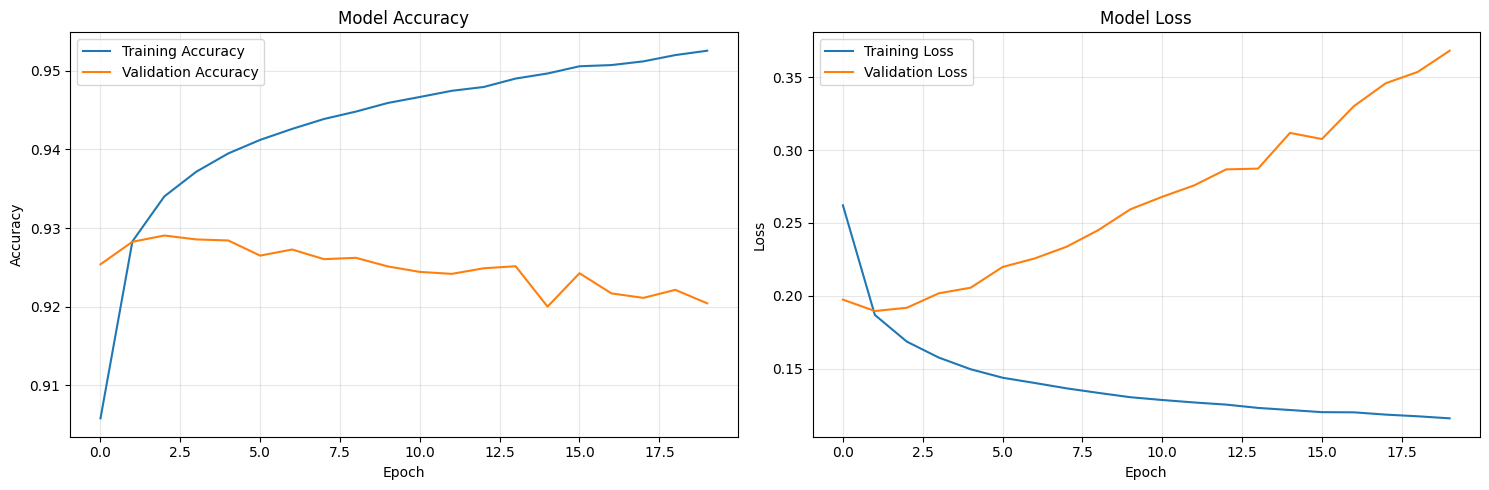

Final Training Results:
Training Accuracy: 0.9526
Validation Accuracy: 0.9204
Training Loss: 0.1159
Validation Loss: 0.3681


In [7]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final training results
print("Final Training Results:")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

## 8. Evaluation

According to the requirements, we need to evaluate the performance of the hybrid system (CNN features + correlation classifier) on the test set and compare it with the standalone CNN performance.

### Metrics:
- **Accuracy:** (Number of correctly classified test images) / (Total number of test images)
- **Error Rate:** E = 1 - Accuracy
- **Comparison:** Report accuracy of both hybrid system and standalone CNN

In [8]:
# Evaluate Standalone CNN Performance
print("Evaluating CNN on Test Set...")
print("=" * 50)

# Get CNN predictions on test set
cnn_predictions = cnn_model.predict(x_test_processed, batch_size=32, verbose=1)
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)

# Calculate CNN metrics
cnn_correct_predictions = np.sum(cnn_predicted_classes == y_test)
cnn_accuracy = cnn_correct_predictions / len(y_test)
cnn_error_rate = 1 - cnn_accuracy

print(f"\nStandalone CNN Results:")
print(f"Correct predictions: {cnn_correct_predictions}/{len(y_test)}")
print(f"Accuracy: {cnn_accuracy:.4f} ({cnn_accuracy*100:.2f}%)")
print(f"Error Rate: {cnn_error_rate:.4f} ({cnn_error_rate*100:.2f}%)")


Evaluating CNN on Test Set...
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 3s 752us/step

Standalone CNN Results:
Correct predictions: 82176/89263
Accuracy: 0.9206 (92.06%)
Error Rate: 0.0794 (7.94%)


In [ ]:
'''# Additional Analysis: Confusion Matrices
print("Generating Confusion Matrices...")

# Create confusion matrices for both methods
from sklearn.metrics import confusion_matrix, classification_report

# CNN Confusion Matrix
cnn_cm = confusion_matrix(y_test, cnn_predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(15, 6))

# CNN Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title(f'CNN Confusion Matrix\nAccuracy: {cnn_accuracy:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.show()
'''
# Per-class accuracy analysis
print("\nPer-Class Accuracy Analysis:")
print("=" * 50)

for class_id in range(num_classes):
    class_mask = (y_test == class_id)
    total_samples = np.sum(class_mask)
    
    # CNN accuracy for this class
    cnn_correct = np.sum((cnn_predicted_classes == class_id) & class_mask)
    cnn_class_acc = cnn_correct / total_samples if total_samples > 0 else 0
    
    # Hybrid accuracy for this class
    
    print(f"Class {class_id}, symbol {class_names[class_id]}: Accuracy={cnn_class_acc:.4f}, Samples={total_samples}")


Per-Class Accuracy Analysis:
Class 0, symbol 0: Accuracy=0.6109, Samples=5778
Class 1, symbol 1: Accuracy=0.8376, Samples=6330
Class 2, symbol 2: Accuracy=0.9131, Samples=5869
Class 3, symbol 3: Accuracy=0.9886, Samples=5969
Class 4, symbol 4: Accuracy=0.9464, Samples=5619
Class 5, symbol 5: Accuracy=0.9262, Samples=5190
Class 6, symbol 6: Accuracy=0.9800, Samples=5705
Class 7, symbol 7: Accuracy=0.9910, Samples=6139
Class 8, symbol 8: Accuracy=0.9483, Samples=5633
Class 9, symbol 9: Accuracy=0.9773, Samples=5686
Class 10, symbol A: Accuracy=0.9322, Samples=1062
Class 11, symbol B: Accuracy=0.8966, Samples=648
Class 12, symbol C: Accuracy=0.9845, Samples=1739
Class 13, symbol D: Accuracy=0.8922, Samples=779
Class 14, symbol E: Accuracy=0.9542, Samples=851
Class 15, symbol F: Accuracy=0.9708, Samples=1440
Class 16, symbol G: Accuracy=0.8456, Samples=447
Class 17, symbol H: Accuracy=0.9117, Samples=521
Class 18, symbol I: Accuracy=0.6698, Samples=2047
Class 19, symbol J: Accuracy=0.9441

### Visual similarities:

- O and '0' and Q and G
- Z and '2'
- S and '5'
- I and '1'
- B and '8'

### Weak points:

- '0' (Digit Zero): 61.09%
- 'I' (Letter I): 66.98%
- 'O' (Letter O): 70.28%
- '1' (Digit One): 83.76%
- 'G' (Letter G): 84.56%

In [10]:
# Save the trained CNN model for later usage
import os
from datetime import datetime

print("Saving CNN Model...")
print("=" * 50)

# Create a models directory if it doesn't exist
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

# Generate timestamp for unique model naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"cnn_alphanumeric_model_{timestamp}"

# Method 1: Save the entire model (recommended)
model_path = os.path.join(models_dir, f"{model_name}.h5")
cnn_model.save(model_path)
print(f"✅ Complete model saved to: {model_path}")

Saving CNN Model...
✅ Complete model saved to: saved_models/cnn_alphanumeric_model_20250601_062953.h5


## 9. Trying to balance classes

In [11]:
# Stratified sampling for train-validation split
from sklearn.model_selection import train_test_split

def create_stratified_split(x_data, y_data, test_size=0.2, random_state=42):
    """
    Create stratified train-validation split ensuring balanced class distribution
    """
    print("Creating stratified train-validation split...")
    print("=" * 50)
    
    # Analyze class distribution before split
    unique_classes, class_counts = np.unique(y_data, return_counts=True)
    print(f"Original class distribution:")
    for cls, count in zip(unique_classes, class_counts):
        print(f"Class {cls}: {count} samples ({count/len(y_data)*100:.2f}%)")
    
    # Perform stratified split
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
        x_data, y_data, 
        test_size=test_size, 
        stratify=y_data,  # This ensures balanced distribution
        random_state=random_state
    )
    
    print(f"\nAfter stratified split:")
    print(f"Training set: {x_train_split.shape[0]} samples")
    print(f"Validation set: {x_val_split.shape[0]} samples")
    
    # Verify stratification worked
    _, train_counts = np.unique(y_train_split, return_counts=True)
    _, val_counts = np.unique(y_val_split, return_counts=True)
    
    print(f"\nClass distribution verification:")
    for i, (cls, orig_count, train_count, val_count) in enumerate(zip(unique_classes, class_counts, train_counts, val_counts)):
        train_pct = train_count / len(y_train_split) * 100
        val_pct = val_count / len(y_val_split) * 100
        print(f"Class {cls}: Train={train_pct:.1f}%, Val={val_pct:.1f}%")
    
    return x_train_split, x_val_split, y_train_split, y_val_split

# Apply stratified split to your data
x_train_stratified, x_val_stratified, y_train_stratified, y_val_stratified = create_stratified_split(
    x_train_processed.reshape(x_train_processed.shape[0], -1),  # Flatten for sklearn
    y_train,
    test_size=0.2
)

# Reshape back for CNN
x_train_stratified = x_train_stratified.reshape(-1, 28, 28, 1)
x_val_stratified = x_val_stratified.reshape(-1, 28, 28, 1)

# Convert to one-hot encoding
y_train_stratified_onehot = keras.utils.to_categorical(y_train_stratified, num_classes)
y_val_stratified_onehot = keras.utils.to_categorical(y_val_stratified, num_classes)

Creating stratified train-validation split...
Original class distribution:
Class 0: 34585 samples (6.48%)
Class 1: 38374 samples (7.19%)
Class 2: 34203 samples (6.41%)
Class 3: 35143 samples (6.58%)
Class 4: 33535 samples (6.28%)
Class 5: 31416 samples (5.88%)
Class 6: 34232 samples (6.41%)
Class 7: 35754 samples (6.70%)
Class 8: 33946 samples (6.36%)
Class 9: 33847 samples (6.34%)
Class 10: 6407 samples (1.20%)
Class 11: 3878 samples (0.73%)
Class 12: 10094 samples (1.89%)
Class 13: 4562 samples (0.85%)
Class 14: 4934 samples (0.92%)
Class 15: 9182 samples (1.72%)
Class 16: 2517 samples (0.47%)
Class 17: 3152 samples (0.59%)
Class 18: 11946 samples (2.24%)
Class 19: 3762 samples (0.70%)
Class 20: 2468 samples (0.46%)
Class 21: 5076 samples (0.95%)
Class 22: 9002 samples (1.69%)
Class 23: 8237 samples (1.54%)
Class 24: 24983 samples (4.68%)
Class 25: 8347 samples (1.56%)
Class 26: 2605 samples (0.49%)
Class 27: 5073 samples (0.95%)
Class 28: 20764 samples (3.89%)
Class 29: 9820 samples

In [12]:
# Calculate class weights to handle imbalance during training
from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weights(y_labels):
    """
    Calculate class weights to balance the loss function
    """
    print("Calculating class weights for imbalanced dataset...")
    
    # Get unique classes and their counts
    unique_classes = np.unique(y_labels)
    
    # Compute class weights using sklearn
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_labels
    )
    
    # Create dictionary mapping class_id -> weight
    class_weight_dict = dict(zip(unique_classes, class_weights))
    
    print(f"Class weights calculated:")
    for cls, weight in class_weight_dict.items():
        print(f"Class {cls}: weight = {weight:.4f}")
    
    return class_weight_dict

# Calculate class weights
class_weights = calculate_class_weights(y_train)

balanced_cnn = cnn_model
# Compile the model again with class weights
balanced_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with class weights
print("\nTraining CNN with class weights...")
history_weighted = balanced_cnn.fit(
    x_train_stratified, y_train_stratified_onehot,
    validation_data=(x_val_stratified, y_val_stratified_onehot),
    batch_size=16,
    epochs=10,
    class_weight=class_weights,  # Apply class weights
    verbose=1
)

Calculating class weights for imbalanced dataset...
Class weights calculated:
Class 0: weight = 0.4289
Class 1: weight = 0.3865
Class 2: weight = 0.4337
Class 3: weight = 0.4221
Class 4: weight = 0.4423
Class 5: weight = 0.4722
Class 6: weight = 0.4333
Class 7: weight = 0.4149
Class 8: weight = 0.4370
Class 9: weight = 0.4382
Class 10: weight = 2.3151
Class 11: weight = 3.8249
Class 12: weight = 1.4695
Class 13: weight = 3.2514
Class 14: weight = 3.0063
Class 15: weight = 1.6155
Class 16: weight = 5.8932
Class 17: weight = 4.7059
Class 18: weight = 1.2417
Class 19: weight = 3.9429
Class 20: weight = 6.0102
Class 21: weight = 2.9222
Class 22: weight = 1.6478
Class 23: weight = 1.8008
Class 24: weight = 0.5937
Class 25: weight = 1.7771
Class 26: weight = 5.6941
Class 27: weight = 2.9239
Class 28: weight = 0.7144
Class 29: weight = 1.5105
Class 30: weight = 1.1770
Class 31: weight = 3.1989
Class 32: weight = 3.1593
Class 33: weight = 5.3530
Class 34: weight = 3.1274
Class 35: weight = 5.4

In [14]:
# Evaluate Standalone CNN Performance
print("Evaluating Balanced CNN on Test Set...")
print("=" * 50)

# Get CNN predictions on test set
cnn_predictions = balanced_cnn.predict(x_test_processed, batch_size=32, verbose=1)
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)

# Calculate CNN metrics
cnn_correct_predictions = np.sum(cnn_predicted_classes == y_test)
cnn_accuracy = cnn_correct_predictions / len(y_test)
cnn_error_rate = 1 - cnn_accuracy

print(f"\nStandalone CNN Results:")
print(f"Correct predictions: {cnn_correct_predictions}/{len(y_test)}")
print(f"Accuracy: {cnn_accuracy:.4f} ({cnn_accuracy*100:.2f}%)")
print(f"Error Rate: {cnn_error_rate:.4f} ({cnn_error_rate*100:.2f}%)")


Evaluating Balanced CNN on Test Set...
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step

Standalone CNN Results:
Correct predictions: 80755/89263
Accuracy: 0.9047 (90.47%)
Error Rate: 0.0953 (9.53%)
